In [56]:
try:
    import nltk
    import findspark
    from nltk.stem import WordNetLemmatizer
    from pyspark import SparkContext
    from pyspark.sql import SparkSession
    from pyspark.sql.functions import lower, regexp_replace, col, split, explode, count, sum as spark_sum, concat_ws, array, udf, collect_list, array_distinct, flatten, to_date, year, month, dayofweek, date_format
    from pyspark.sql.types import ArrayType, StringType, DoubleType
    from pyspark.ml.feature import StopWordsRemover, Tokenizer, NGram, CountVectorizer
    from pyspark.ml.clustering import LDA
    import pandas as pd
    from textblob import TextBlob
    import matplotlib.pyplot as plt
    import seaborn as sns
    from functools import reduce
except:
    print("downloading stuff...")
    %pip install pyspark
    %pip install pandas
    %pip install textblob
    %pip install matplotlib
    %pip install --upgrade seaborn
    %pip install functools
    %pip install nltk
    %pip install findspark
    import nltk
    import findspark
    from nltk.stem import WordNetLemmatizer
    from pyspark import SparkContext
    from pyspark.sql import SparkSession
    from pyspark.sql.functions import lower, regexp_replace, col, split, explode, count, sum as spark_sum, concat_ws, array, udf, collect_list, array_distinct, flatten, to_date, year, month, dayofweek, date_format
    from pyspark.sql.types import ArrayType, StringType, DoubleType
    from pyspark.ml.feature import StopWordsRemover, Tokenizer, NGram, CountVectorizer
    from pyspark.ml.clustering import LDA
    import pandas as pd
    from textblob import TextBlob
    import matplotlib.pyplot as plt
    import seaborn as sns
    from functools import reduce

pd.set_option('display.max_colwidth', None)

In [57]:
def show_pandas_df(spark_df, limit = None, *columns):
    if not columns:
        if limit is not None:
            return spark_df.limit(limit).toPandas()
        else:
            return spark_df.toPandas()
    else:
        return spark_df.select(*columns).limit(limit).toPandas()

In [58]:
findspark.init()
spark = SparkSession.builder \
    .appName("EiffelTowerTweetsAnalysis") \
    .config("spark.executor.memory", "2g") \
    .config("spark.driver.memory", "2g") \
    .config("spark.network.timeout", "800s") \
    .config("spark.sql.shuffle.partitions", "2") \
    .config("spark.python.worker.reuse", "false") \
    .getOrCreate()


df = spark.read.json("../../datasets/eiffel-tower-reviews.json")

show_pandas_df(df, 10, 'createdAt', 'title', 'text')

,createdAt,title,text
0,"May 20, 2017",Must do even it was so busy,This is the most busiest atttaction in Paris and there are some nice restaurants on it and the views were spectacular and this is the top must do in Paris
1,"May 20, 2017",A Classic,"My significant other and I drunkenly stumbled here a few weeks back. For a 'cliche' type experience it certainly was absolutely incredible. We popped in around 2200, and the Tower was beautifully lit. The view from the top is fantastic, but be prepared to dress warm. Definitely cold up there."
2,"May 20, 2017",Wet weather,"We had a tour to the Eiffel Tower while we were in Paris. Unfortunately one of the cable cars was down while there, which made the wait times a little longer even with skip the queue passes."
3,"May 20, 2017",Not to be missed,Visited with my wife and son.
4,"May 20, 2017",Awesome!!!,We went in the night at 10pm to see the illumination of Paris that is Eiffel Tower. It was very very beautiful to see the Eiffel all lit up beautifully. At 10pm there is special illumination which ch starts and last for 5 mins. Its like millions of leds starts blinking. Covering the entire tower. I was awe stuck to see the sight. Must must go.
5,"May 20, 2017",Iconic place for anyone visiting France,Dont hesitate and got all the way up to the top. The view is inspiring. Be early in the morning to avoid lines or late in the afternoon to enjoy the sunset. Make sure to look at the tower from the streets (or Sena river) around 21:00 hours to see some extra lights !!!!!
6,"May 20, 2017",Delightful,"I enjoyed the tower with my kids, and went to the top, beautiful views, with some lovely photos, an iconic building I had to see while there,"
7,"May 20, 2017",Wonderful experience at night,Read through the history of the Eiffel Tower and enjoy it's magnificence twice - once during the day at close quarters and second at night. Wonderful going into history.
8,"May 20, 2017",Wow,This by far was our favourite part of Europe. Nothing can compare to seeing this amazing piece of architecture in real life. It is simply breathtaking? Make this your number one priority on any trip to Europe
9,"May 19, 2017",Great,Something you have to do when you visit Paris. Its a must ☺️. The views are breath taking. Really beautiful


In [59]:
data = df.select("createdAt").dropna()

# Setando o parser para o modo legacy (só assim funciona)
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
data = data.withColumn('createdAt', to_date('createdAt', 'MMMMM dd, yyyy')) \
    .withColumn('year_month', date_format("createdAt", "yyyy-MM")) \
    .sort(col('year_month').desc())

data = data.groupBy("year_month").agg(count("year_month").alias("count")).withColumn("createdAt", to_date("year_month", "yyyy-MM")).select('year_month', 'count')
data = show_pandas_df(data)
data

,year_month,count
0,2017-04,326
1,2017-03,212
2,2017-01,226
3,2016-09,394
4,2016-08,487
5,2016-07,467
6,2016-05,352
7,2016-04,372
8,2015-12,268
9,2015-11,286


### Distribuição temporal com base no ano-mês

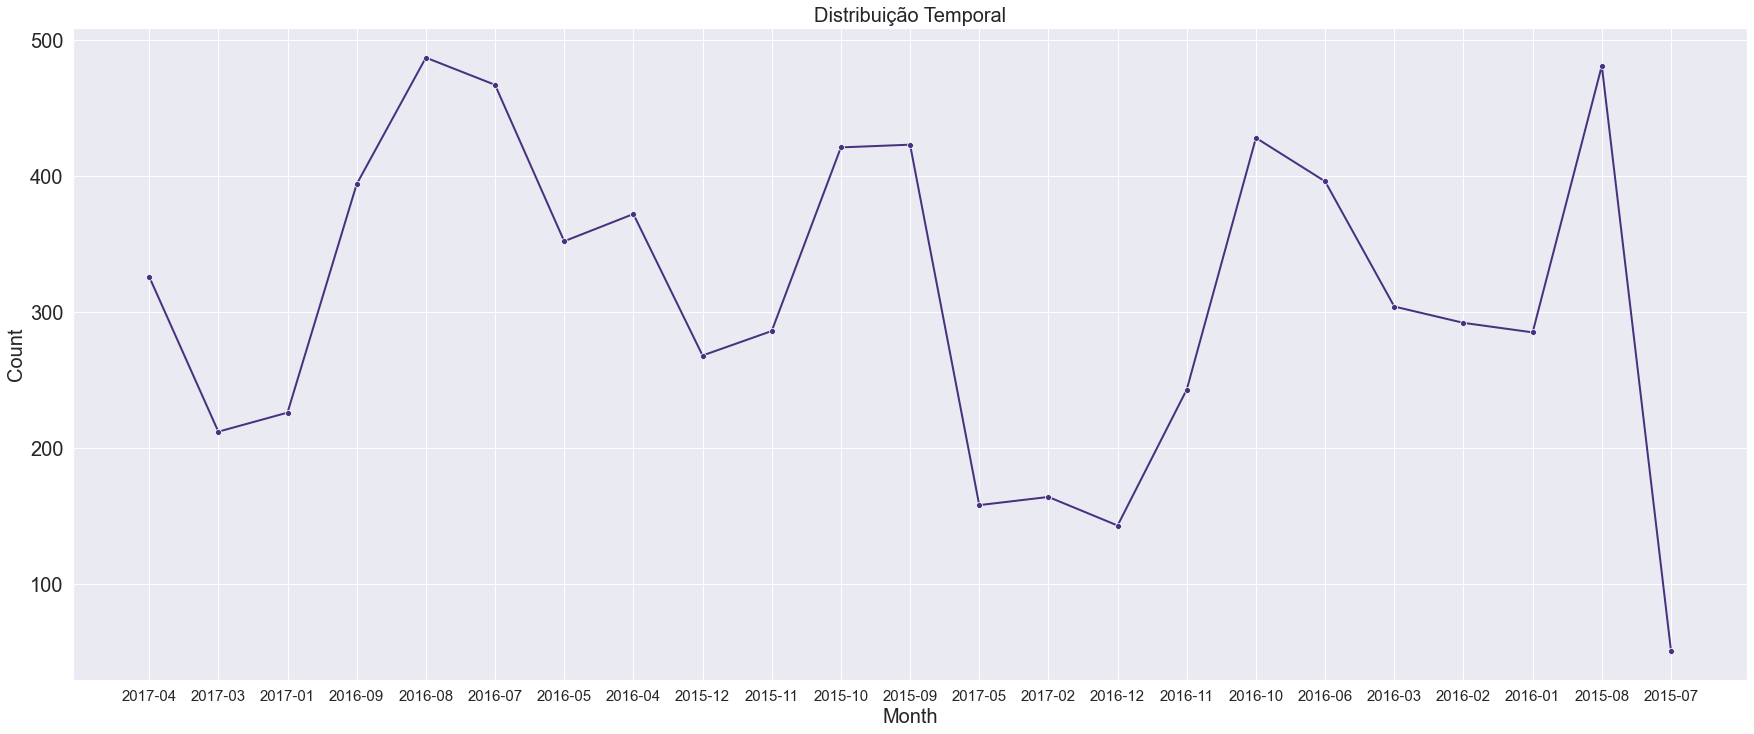

In [60]:
sns.set_style("darkgrid")  
sns.set_palette("viridis")

plt.figure(figsize=(30, 12))
sns.lineplot(x='year_month', y='count', data=data, linewidth=2, marker='o', sort=False)
plt.ylabel('Count', fontsize=20)
plt.xlabel('Month', fontsize=20)
plt.title('Distribuição Temporal', fontsize=20)
plt.grid(True)

plt.xticks(ticks=list(data['year_month']), fontsize=15)
plt.yticks(fontsize=20)
plt.show()

In [77]:
@udf(returnType=DoubleType())
def analyze_sentiment(text):
    return TextBlob(text).sentiment.polarity

In [86]:
reviews_df = df.select("text").dropna().withColumn("text_cleaned", lower(col("text"))) \
    .withColumn("text_cleaned", regexp_replace(col("text_cleaned"), "[^a-zA-Z\\s]", ""))

sentiment_distribution = reviews_df.withColumn("sentiment", analyze_sentiment(col("text_cleaned"))).toPandas()
sentiment_distribution

,text,clean_text,sentiment
0,This is the most busiest atttaction in Paris and there are some nice restaurants on it and the views were spectacular and this is the top must do in Paris,this is the most busiest atttaction in paris and there are some nice restaurants on it and the views were spectacular and this is the top must do in paris,0.550000
1,"My significant other and I drunkenly stumbled here a few weeks back. For a 'cliche' type experience it certainly was absolutely incredible. We popped in around 2200, and the Tower was beautifully lit. The view from the top is fantastic, but be prepared to dress warm. Definitely cold up there.",my significant other and i drunkenly stumbled here a few weeks back for a cliche type experience it certainly was absolutely incredible we popped in around and the tower was beautifully lit the view from the top is fantastic but be prepared to dress warm definitely cold up there,0.264935
2,"We had a tour to the Eiffel Tower while we were in Paris. Unfortunately one of the cable cars was down while there, which made the wait times a little longer even with skip the queue passes.",we had a tour to the eiffel tower while we were in paris unfortunately one of the cable cars was down while there which made the wait times a little longer even with skip the queue passes,-0.281019
3,Visited with my wife and son.,visited with my wife and son,0.000000
4,We went in the night at 10pm to see the illumination of Paris that is Eiffel Tower. It was very very beautiful to see the Eiffel all lit up beautifully. At 10pm there is special illumination which ch starts and last for 5 mins. Its like millions of leds starts blinking. Covering the entire tower. I was awe stuck to see the sight. Must must go.,we went in the night at pm to see the illumination of paris that is eiffel tower it was very very beautiful to see the eiffel all lit up beautifully at pm there is special illumination which ch starts and last for mins its like millions of leds starts blinking covering the entire tower i was awe stuck to see the sight must must go,0.441429
...,...,...,...
7171,"We recently visited the Eiffel Tower on our trip to Paris, of course, it's a must! Over all it was a great experience except for the line up for tickets, bearing in mind it was 37 degrees there was no shade and the water must spray was in completed the wrong position to provide any relief. I felt for the families with older people and young kids. If the weather is warm I'd advise on a hat and plenty of water.",we recently visited the eiffel tower on our trip to paris of course its a must over all it was a great experience except for the line up for tickets bearing in mind it was degrees there was no shade and the water must spray was in completed the wrong position to provide any relief i felt for the families with older people and young kids if the weather is warm id advise on a hat and plenty of water,0.194444
7172,Getting through the lines is impossible or at lest will take up a large chunk of your day. One can certainly say it is easy to find...,getting through the lines is impossible or at lest will take up a large chunk of your day one can certainly say it is easy to find,0.048810
7173,One must not be there to be served and one will never be there to find himself alone enjoying the Eiffel Tower all by himself.,one must not be there to be served and one will never be there to find himself alone enjoying the eiffel tower all by himself,0.500000
7174,Loved the Eiffel tower this was my 2nd visit and going at night is great from the ground the night we went was misty you couldn't see much but still an amazing experience!!,loved the eiffel tower this was my nd visit and going at night is great from the ground the night we went was misty you couldnt see much but still an amazing experience,0.575000


### Histograma de Sentimento

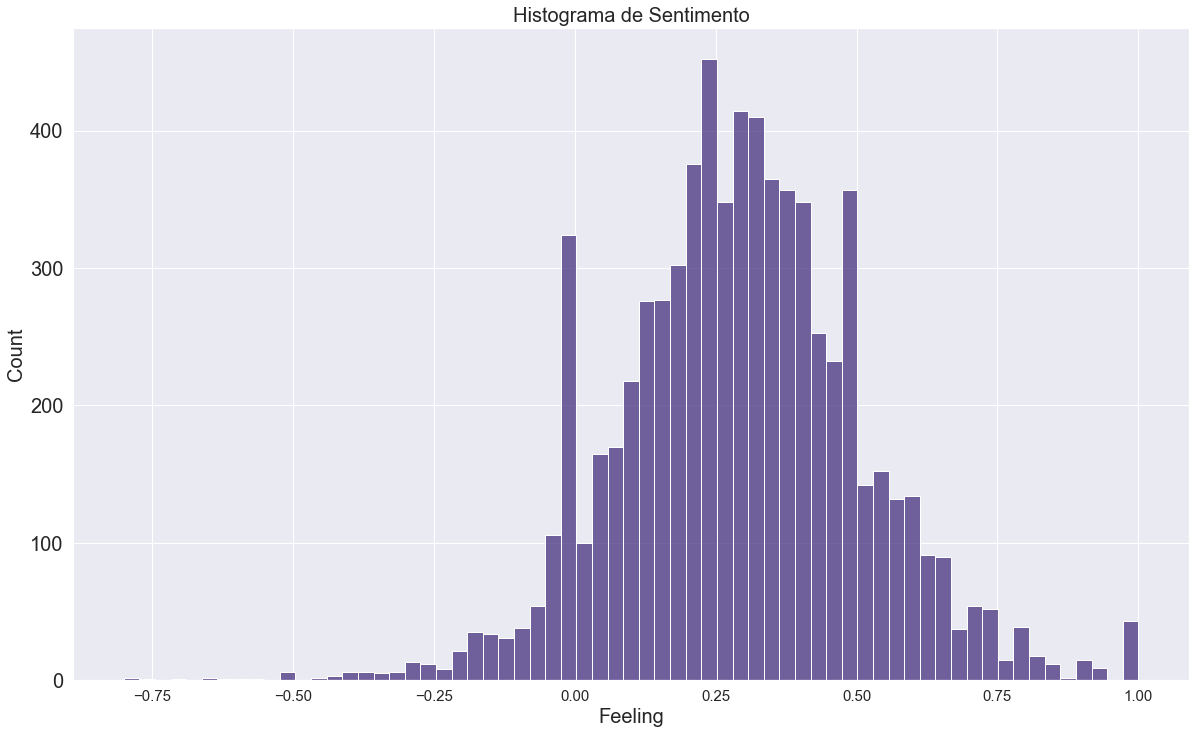

In [87]:
sns.set_style("darkgrid")  
sns.set_palette("viridis")

plt.figure(figsize=(20, 12))
sns.histplot(x='sentiment', data=sentiment_distribution)
plt.xlabel('Feeling', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.title('Histograma de Sentimento', fontsize=20)
plt.grid(True)

plt.xticks(fontsize=15)
plt.yticks(fontsize=20)
plt.show()